In [1]:
from scipy.spatial.transform import Rotation as R
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from LightTransportSimulator.RayVectors.utils import nearest_intersected_object
from LightTransportSimulator.RayVectors.intersects import sphere_intersect
from LightTransportSimulator.RayVectors.vectors import *
from LightTransportSimulator.RayVectors.rays import *

In [3]:
camera = np.array([0, 0, 1])

In [4]:
width = 400
height = 400
aspect_ratio = width/height
screen = {'left': -1, 'top': 1 / aspect_ratio, 'right': 1, 'bottom': -1 / aspect_ratio}
max_depth = 3

In [22]:
light_source = { 'position': np.array([0, 3.9, 2]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

In [23]:
objects = [
    {'type': 'sphere', 'geom_props': { 'center': np.array([-0.2, 0, -1]), 'radius': 0.7 }, 'light_props': { 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'sphere', 'geom_props': { 'center': np.array([0.1, -0.3, 0]), 'radius': 0.1 }, 'light_props': { 'ambient': np.array([0.1, 0, 0.1]), 'diffuse': np.array([0.7, 0, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'sphere', 'geom_props': { 'center': np.array([-0.3, 0, 0]), 'radius': 0.15 }, 'light_props': { 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'id': 'back_wall', 'type': 'plane', 'geom_props': { 'point': np.array([0.0, 0.0, -4.0]), 'normal': np.array([0.0, 0.0, 1.0]) }, 'light_props': { 'ambient': np.array([0.23125, 0.23125, 0.23125]), 'diffuse': np.array([0.2775, 0.2775, 0.2775]), 'specular': np.array([0.773911, 0.773911, 0.773911]), 'shininess': 89.6, 'reflection': 0.5 }},
    {'id': 'left_wall', 'type': 'plane',
     'geom_props': {'point': np.array([-4.0, 0.0, 0.0]), 'normal': np.array([1.0, 0.0, 0.0])},
     'light_props': {'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]),
                     'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5}},
    {'id': 'right_wall', 'type': 'plane',
     'geom_props': {'point': np.array([4, 0.0, 0.0]), 'normal': np.array([-1.0, 0.0, 0.0])},
     'light_props': { 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'id': 'top_wall', 'type': 'plane',
     'geom_props': {'point': np.array([0.0, 4.0, 0.0]), 'normal': np.array([0.0, -1.0, 0.0])},
     'light_props': { 'ambient': np.array([0.23125, 0.23125, 0.23125]), 'diffuse': np.array([0.2775, 0.2775, 0.2775]), 'specular': np.array([0.773911, 0.773911, 0.773911]), 'shininess': 89.6, 'reflection': 0.5 }},
    {'id': 'bottom_wall', 'type': 'plane',
     'geom_props': {'point': np.array([0.0, -4.0, 0.0]), 'normal': np.array([0.0, 1.0, 0.0])},
     'light_props': { 'ambient': np.array([0.23125, 0.23125, 0.23125]), 'diffuse': np.array([0.2775, 0.2775, 0.2775]), 'specular': np.array([0.773911, 0.773911, 0.773911]), 'shininess': 89.6, 'reflection': 0.5 }},
]

In [24]:
image = np.zeros((height, width, 3))

In [25]:
for i, y in enumerate(np.linspace(screen['top'], screen['bottom'], height)):
    for j, x in enumerate(np.linspace(screen['left'], screen['right'], width)):
        # screen is on origin
        pixel = np.array([x, y, 0])
        origin = camera
        end = pixel
        direction = normalize(end - origin)

        color = np.zeros((3))
        reflection = 1

        for k in range(max_depth):
            # check for intersections
            nearest_object, min_distance = nearest_intersected_object(objects, origin, end)

            if nearest_object is None:
                break

            intersection = origin + min_distance * direction

            if nearest_object['type'] == 'sphere':
                normal_to_surface = normalize(intersection - nearest_object['geom_props']['center'])
            elif nearest_object['type'] == 'triangle':
                ab = nearest_object['geom_props']['b'] - nearest_object['geom_props']['a']
                ac = nearest_object['geom_props']['c'] - nearest_object['geom_props']['a']
                normal_to_surface = np.cross(ab, ac)
            else:
                normal_to_surface = nearest_object['geom_props']['normal']

            shifted_point = intersection + 1e-5 * normal_to_surface

            intersection_to_light = normalize(light_source['position'] - shifted_point)

            _, min_distance = nearest_intersected_object(objects, shifted_point, light_source['position'])
            intersection_to_light_distance = np.linalg.norm(light_source['position'] - intersection)
            is_shadowed = min_distance < intersection_to_light_distance

            if is_shadowed:
                break

            illumination = np.zeros((3))

            # ambiant
            illumination += get_ambience(nearest_object['light_props']['ambient'], light_source['ambient'])

            # diffuse
            illumination += get_diffuse(nearest_object['light_props']['diffuse'], light_source['diffuse'], intersection_to_light, normal_to_surface)

            # specular
            intersection_to_camera = normalize(camera - intersection)
            viewing_direction = normalize(intersection_to_light + intersection_to_camera)
            illumination += get_specular(nearest_object['light_props']['specular'], light_source['specular'], viewing_direction, normal_to_surface, nearest_object['light_props']['shininess'])

            # reflection
            color += reflection * illumination

            reflection *= nearest_object['light_props']['reflection']

            origin = shifted_point
            direction = reflected_ray(direction, normal_to_surface)

        image[i, j] = np.clip(color, 0, 1)
    print("%d/%d" % (i + 1, height))


1/400
2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400
20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400
32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/400
139/

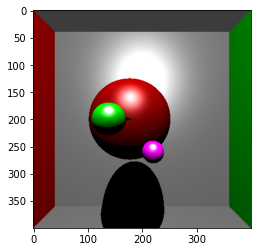

In [26]:
plt.imshow(image)